### **Enhancing the Effectiveness of Online Experiments using CUPED: A Case Study of Booking.com**

In [ ]:
# Import necessary libraries
import random
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest, ttest_ind
from scipy import stats

In [ ]:
# Define variables
N = 1000 # Number of samples
pre_mean = 100 # Mean of pre-experiment data
pre_sigma = 50 # Standard deviation of pre-experiment data
exp_sigma = 20 # Standard deviation of experimental data
treat_lift = 5 # Lift in treatment group

seed = 1122 
np.random.seed(seed)

In [ ]:
# Generate pre-experiment data for control and treatment groups
control_pre = list(np.random.normal(loc=pre_mean, scale=pre_sigma, size=N))
treat_pre = list(np.random.normal(loc=pre_mean, scale=pre_sigma, size=N))

In [ ]:
# Generate experimental data for control and treatment groups
control = np.zeros(N)
treatment = np.zeros(N)

In [ ]:
for i in range(0,N,1):
    control[i] = control_pre[i] + np.random.normal(loc=0, scale=exp_sigma)
    treatment[i] = treat_pre[i] + np.random.normal(loc=0, scale=exp_sigma) + treat_lift

In [ ]:
# Combine pre-experiment and experimental data for control and treatment groups
pre_data = []
pre_data.extend(control_pre)
pre_data.extend(treat_pre)

In [ ]:
post_data = []
post_data.extend(control)
post_data.extend(treatment)

<ipython-input-9-d7e32a3650a1>:4: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(pre_data, bw=0.5)
<ipython-input-9-d7e32a3650a1>:5: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(post_data, bw=0.5)


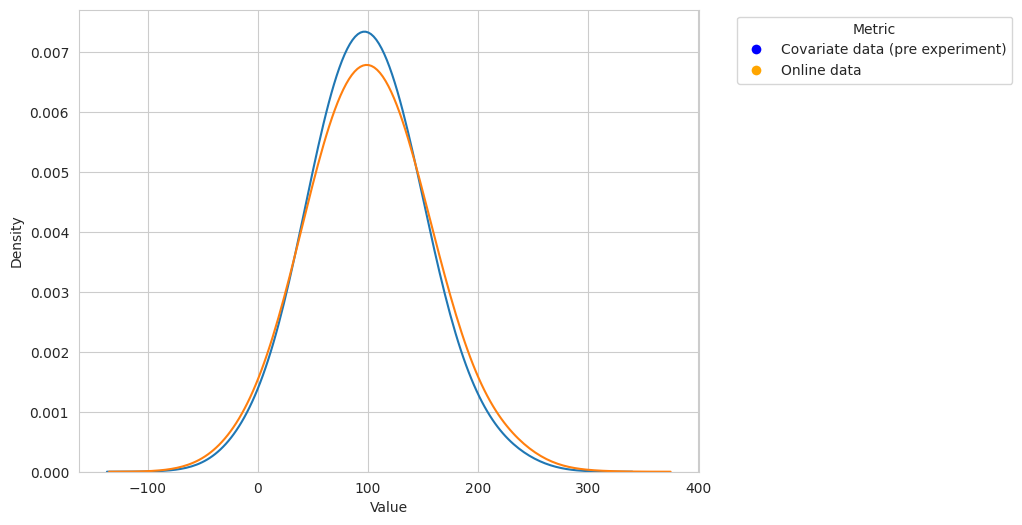

In [ ]:
# Plot pre-experiment and experimental data using kernel density estimation
plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')
sns.kdeplot(pre_data, bw=0.5)
sns.kdeplot(post_data, bw=0.5)
plt.xlabel("Value")
plt.ylabel("Density")
# Create a custom legend for the plot
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Covariate data (pre experiment)', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Online data', markerfacecolor='orange', markersize=8)
]
plt.legend(handles=legend_elements, title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(handles=legend_elements, title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
# Create a dataframe to store the data
user_id = [i + 1 for i in range(0,2*N,1)]
assigment = ["control"]*N+["treatment"]*N

data = pd.DataFrame({'User id': user_id,
                      'Assigment': assigment,
                     "Online synthetic metric":post_data,
                     "Covariate (pre syntheic data)":pre_data})

In [ ]:
data.sample(frac = 1).head()

,User id,Assigment,Online synthetic metric,Covariate (pre syntheic data)
1095,1096,treatment,79.454720,72.539291
1868,1869,treatment,59.833271,69.932246
1778,1779,treatment,76.400231,55.863242
374,375,control,53.952427,41.911214
338,339,control,94.844383,84.387060


Lets observe what happends without adjusting our metric:

In [ ]:
# Separate the adjusted data for control and treatment groups
control_unadj = data[data['Assigment'] == "control"]['Online synthetic metric']
treat_unadj = data[data['Assigment'] == "treatment"]['Online synthetic metric']

<ipython-input-15-3b6ad84fffde>:4: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(control_unadj, bw=0.5)
<ipython-input-15-3b6ad84fffde>:5: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(treat_unadj, bw=0.5)


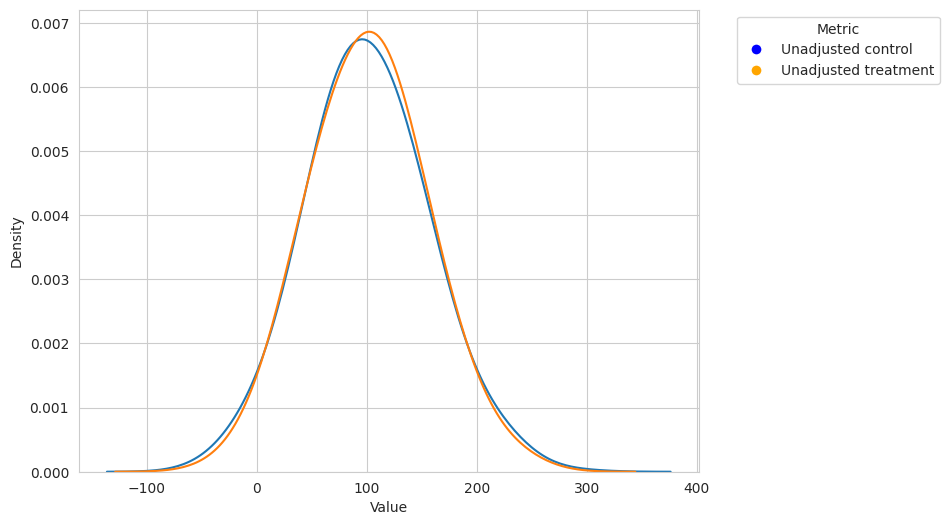

In [ ]:
# Plot the unadjusted data for control and treatment groups using kernel density estimation
plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')
sns.kdeplot(control_unadj, bw=0.5)
sns.kdeplot(treat_unadj, bw=0.5)

plt.xlabel("Value")
plt.ylabel("Density")

# Create a custom legend for the plot
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Unadjusted control', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Unadjusted treatment', markerfacecolor='orange', markersize=8)
]
plt.legend(handles=legend_elements, title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

$H_0$ = no detectable effect vs $H_1$ = there is some effect

In [ ]:
unadj_control = data[data['Assigment'] == "control"]['Online synthetic metric']
unadj_treat = data[data['Assigment'] == "treatment"]['Online synthetic metric']
stats.ttest_ind(unadj_control, unadj_treat)

Ttest_indResult(statistic=-0.21348403845826502, pvalue=0.8309712187775029)

Let $\alpha$ = 0.05 then we can see that we fail to reject $H_0$ meaning there is no detectable effect

In [ ]:
# Calculate the theta value for Cuped adjustment
theta = np.cov(data['Online synthetic metric'],data['Covariate (pre syntheic data)'])[0][1]/np.var(data['Covariate (pre syntheic data)'])

In [ ]:
# Calculate the Cuped adjusted data for control and treatment groups
cuped_adjusted  = data['Online synthetic metric'] - (data['Covariate (pre syntheic data)']- np.mean(data['Covariate (pre syntheic data)']))*theta

In [ ]:
# Add the Cuped adjusted data to the dataframe
data['Cuped adjusted metric'] = cuped_adjusted

In [ ]:
data.head()

,User id,Assigment,Online synthetic metric,Covariate (pre syntheic data),Cuped adjusted metric
0,1,control,21.517699,46.212591,74.180595
1,2,control,142.234067,132.842587,108.443111
2,3,control,38.011016,38.876750,97.994837
3,4,control,72.890766,76.664851,95.163321
4,5,control,38.912655,44.935965,92.849581


**Notice** that in this experiment we are not considering when we dont have data about a user on pre experiment for covariate meaning that user have Null for the covariate. If that were the case then the Cuped adjusted metric for that user will be just the online metric itself without adjustment.

Lets see the difference in variance between the unadjusted metric and the Cuped adjusted metric:

<ipython-input-22-3ab181856398>:4: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(post_data, bw=0.5)
<ipython-input-22-3ab181856398>:5: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data['Cuped adjusted metric'], bw=0.5)


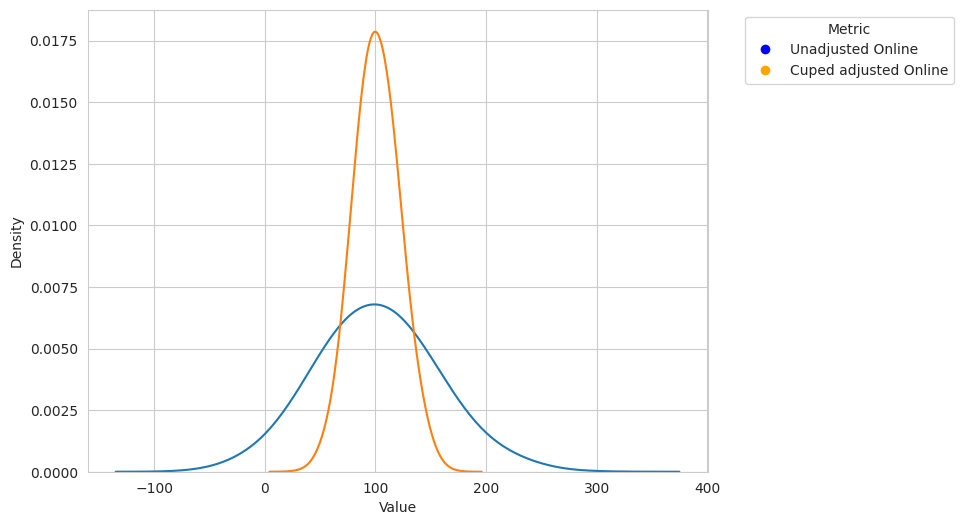

In [ ]:
# Plot the unadjusted and Cuped adjusted data for control and treatment groups using kernel density estimation
plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')
sns.kdeplot(post_data, bw=0.5)
sns.kdeplot(data['Cuped adjusted metric'], bw=0.5)
plt.xlabel("Value")
plt.ylabel("Density")

# Create a custom legend for the plot
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Unadjusted Online', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Cuped adjusted Online', markerfacecolor='orange', markersize=8)
]
plt.legend(handles=legend_elements, title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

Now this is what happens for control and treatrment when we apply CUPED and we used our adjusted data:

In [ ]:
# Separate the Cuped adjusted data for control and treatment groups
control_adj = data[data['Assigment'] == "control"]['Cuped adjusted metric']
treat_adj = data[data['Assigment'] == "treatment"]['Cuped adjusted metric']

<ipython-input-24-e96643445158>:4: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(control_adj, bw=0.5)
<ipython-input-24-e96643445158>:5: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(treat_adj, bw=0.5)


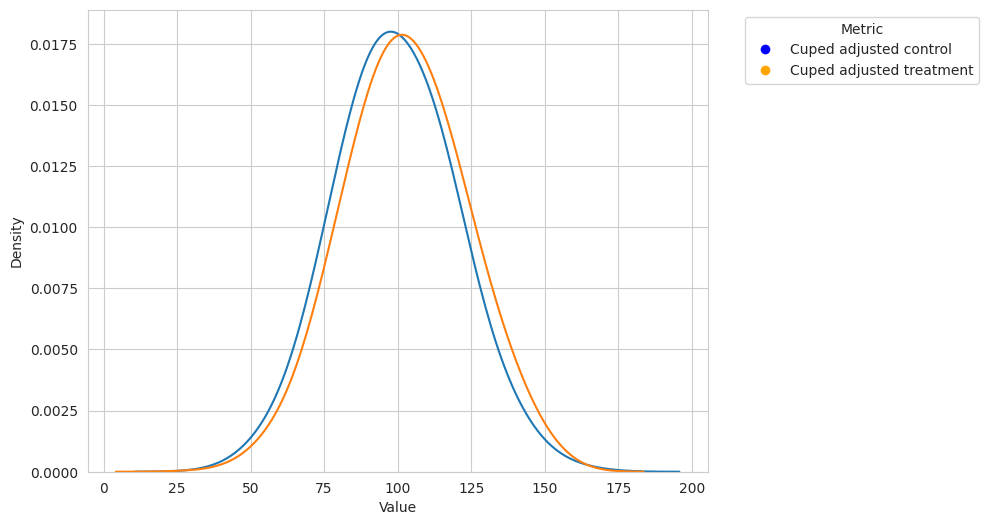

In [ ]:
# Plot the Cuped adjusted data for control and treatment groups using kernel density estimation
plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')
sns.kdeplot(control_adj, bw=0.5)
sns.kdeplot(treat_adj, bw=0.5)

plt.xlabel("Value")
plt.ylabel("Density")

# Create a custom legend for the plot
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Cuped adjusted control', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Cuped adjusted treatment', markerfacecolor='orange', markersize=8)
]
plt.legend(handles=legend_elements, title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

$H_0$ = no detectable effect vs $H_1$ = there is some effect

In [ ]:
# Calculate the p-value for the t-test between Cuped adjusted data for control and treatment groups
stats.ttest_ind(control_adj, treat_adj)[1]

0.00016109469169758018

Since $\alpha$ = 0.05 then we can see that we reject $H_0$ meaning there is some effect. 

Now that we used our Cuped metric we were able to detect the effect that previously we were not able to get before.